This is a walkthrough notebook for illustrating the functionality of the library functions. At the same time, it highlights the key steps in the analysis presented in the BioArxiv paper.

You can download example videos used in the paper at the following Google Drive Link:
https://drive.google.com/drive/folders/0BwFVL6r9ww5BaTh6NExLR1JMUXM
organised into two folders,
    0% FBS - for no serum videos
    5% FBS - for added serum videos
    
In the following we assumed you have downloaded and saved the videofile, 'c_EPC2(G)_CP-A(R)_KSFM+RPMI_5_Fast GFP.tif_R-G.tif' into the root folder of the repository. We also use Python 2.7.

### Load Libraries

We will first load some required libraries.

In [2]:
from scipy.misc import imsave
import pylab as plt 
import scipy.io as spio
import numpy as np
from skimage.filters import gaussian

# These are from MOSES.
from Optical_Flow_Tracking.superpixel_track import compute_grayscale_vid_superpixel_tracks
from Utility_Functions.file_io import read_multiimg_PIL
from Visualisation_Tools.track_plotting import plot_tracks
from Track_Filtering.filter_meantracks_superpixels import filter_red_green_tracks
from Motion_Analysis.mesh_statistics_tools import construct_MOSES_mesh, from_neighbor_list_to_graph, compute_MOSES_mesh_strain_curve, compute_motion_saliency_map, compute_boundary_formation_index, compute_MOSES_motion_stability_index, compute_max_vccf_cells_before_after_gap, compute_mesh_disorder, compute_spatial_correlation_function, compute_mesh_disorder_index
from Motion_Analysis.wound_close_sweepline_area_segmentation import wound_sweep_area_segmentation
from Visualisation_Tools.mesh_visualisation import visualise_mesh

### Step 0: Read Video

Note: Functionality in the library is only provided to read videos as multi-page tiffs. For additional formats such as .mp4, .avi etc. please refer to the excellent moviepy library which can be installed through conda or pip.

In [3]:
"""
1. Specify input file location and read the multipage .tif video.
"""

infile = 'c_EPC2(G)_CP-A(R)_KSFM+RPMI_5_Fast GFP.tif_R-G.tif'

print 'reading .tif video ...'

vidstack = read_multiimg_PIL(infile)
_, n_rows, n_cols, _ = vidstack.shape


reading .tif video ...


### Step 1: Motion Extraction

Next we define some recommended parameters for extracting motion with optical flow to produce superpixel tracks.

In [4]:
#==============================================================================
#   Defining some motion extraction default params, (these work for a lot of videos particularly the optical flow params.)  
#==============================================================================
    
# optical flow tracking parameters (doesn't really matter a lot, c.f. OpenCV for details of Farneback optical flow)
optical_flow_params = dict(pyr_scale=0.5, levels=3, winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)

# number of superpixels
n_spixels = 1000

In [5]:
"""
2. Extract global motion in superpixel tracks with optical flow algorithm, one set of tracks for each relevant color channel.

*MAY BE SLOW ... *, wait a few minutes.

"""
print 'extracting superpixel tracks from video, can be slow...'
meantracks_r = compute_grayscale_vid_superpixel_tracks(vidstack[:,:,:,0], optical_flow_params, n_spixels)
meantracks_g = compute_grayscale_vid_superpixel_tracks(vidstack[:,:,:,1], optical_flow_params, n_spixels)

# save the output, to avoid recomputing later:
savetracksmat = ('meantracks_'+infile).replace('.tif', '.mat')
spio.savemat(savetracksmat, {'meantracks_r':meantracks_r, 
                             'meantracks_g':meantracks_g})

extracting superpixel tracks from video, can be slow...


We can have visualize the extracted motion tracks to check whether they are correct qualitatively using the provided plot_tracks script.

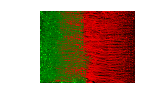

In [6]:
# used to plot matplotlib figures with no boundaries with the following code snippet.
width = float(n_cols)
height = float(n_rows)

# visualize the tracks along with first frame, you might notice 'contamination' of tracks, we can clean with up with post track filtering
fig = plt.figure()
fig.set_size_inches(width/height, 1, forward=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(vidstack[0])
plot_tracks(meantracks_r, ax, color='r', lw=.2)
plot_tracks(meantracks_g, ax, color='g', lw=.2)
ax.set_xlim([0, n_cols])
ax.set_ylim([n_rows, 0])
ax.grid('off')
ax.axis('off')
fig.savefig(('tracksimg-no-filt_'+infile).replace('.tif', '.png'), dpi=height)
plt.show()

The extracted motion tracks may be noisy. In the post-processing steps we aim to clean the tracks up by retaining only the superpixel tracks relevant to each initial object of interest here, the respective red and green epithelial sheets.

**Note**: this process is specific for such two cell population assays. You can clean the tracks in other ways for other assays e.g. through image segmentation of the objects and keeping only the tracks that cover the objects of interest.

post filtering tracks for epithelial sheet migration videos, can be slow...


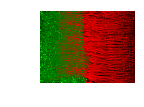

In [7]:
"""
3. Post Filtering of Superpixel Tracks.
"""
print 'post filtering tracks for epithelial sheet migration videos, can be slow...'

# frame2 is the maximum frame number which we estimate the initially moving superpixels to determine which superpixel tracks belong to the initial epithelial sheets.
meantracks_r, meantracks_g = filter_red_green_tracks(meantracks_r, meantracks_g, img_shape=(n_rows, n_cols), frame2=1)


fig = plt.figure()
fig.set_size_inches(width/height, 1, forward=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(vidstack[0])
plot_tracks(meantracks_r, ax, color='r', lw=.2)
plot_tracks(meantracks_g, ax, color='g', lw=.2)
ax.set_xlim([0, n_cols])
ax.set_ylim([n_rows, 0])
ax.grid('off')
ax.axis('off')
fig.savefig(('tracksimg-filt_'+infile).replace('.tif', '.png'), dpi=height)
plt.show()


#  save the improved tracks, now we only use these for all downstream analysis e.g. to compute statistics etc.
savetracksmat = ('meantracks-filt_'+infile).replace('.tif', '.mat')
spio.savemat(savetracksmat, {'meantracks_r':meantracks_r,
                             'meantracks_g':meantracks_g})

### 2. Forming the MOSES Mesh from Superpixel Tracks

A key novelty of MOSES is the formation of a mesh from superpixel tracks to account for local collective dynamics as well as to reduce noise. Different meshes can be specified limited only by the definition of 'neighbour'. In the paper we define the neighbourhood as the radially closest neighbours up to a radial euclidean distance threshold to each superpixel based on their initial position in frame 0.

We show how to compute this definition below and visualize a select frame here frame 20 as illustration. We also show how to compute the local averaged mesh strain.

In [8]:
# we can load the saved improved tracks without executing the previous steps.
# example of loading up the saved .mat object 
meantracks_r = spio.loadmat(('meantracks-filt_'+infile).replace('.tif', '.mat'))['meantracks_r']
meantracks_g = spio.loadmat(('meantracks-filt_'+infile).replace('.tif', '.mat'))['meantracks_g']
    
# get the average superpixel size. (this is effectively the resolution of the tracking and used again and again to set automatic thresholds.). It is therefore very useful to compute this from the very outset.
spixel_size = meantracks_r[1,0,1] - meantracks_r[1,0,0]

"""
4. MOSES mesh computation, we compute a mesh for each, and visualise the state of the mesh at frame 20 as example. 
"""
print 'Computing MOSES Mesh ...'
MOSES_mesh_strain_time_r, MOSES_mesh_neighborlist_r = construct_MOSES_mesh(meantracks_r, dist_thresh=1.2, spixel_size=spixel_size)
MOSES_mesh_strain_time_g, MOSES_mesh_neighborlist_g = construct_MOSES_mesh(meantracks_g, dist_thresh=1.2, spixel_size=spixel_size)

# visualise the two meshes independently by exploiting networkx for a chosen frame .e.g. 20, first turn the neighborlist into a networkx graph object.
mesh_frame20_networkx_G_red = from_neighbor_list_to_graph(meantracks_r, MOSES_mesh_neighborlist_r, 20)
mesh_frame20_networkx_G_green = from_neighbor_list_to_graph(meantracks_g, MOSES_mesh_neighborlist_g, 20)

# save the mesh visualization with no borders. 
width = float(n_cols)
height = float(n_rows)

fig = plt.figure()
fig.set_size_inches(width/height, 1, forward=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(vidstack[20], alpha=0.7)
visualise_mesh(mesh_frame20_networkx_G_red, meantracks_r[:,20,[1,0]], ax, node_size=.2, node_color='r')
ax.set_ylim([n_rows,0])
ax.set_xlim([0,n_cols])
fig.savefig('mesh_frame20_red.png', dpi=height)

fig = plt.figure()
fig.set_size_inches(width/height, 1, forward=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(vidstack[20], alpha=0.7)
visualise_mesh(mesh_frame20_networkx_G_green, meantracks_g[:,20,[1,0]], ax, node_size=.2, node_color='g')
ax.set_ylim([n_rows,0])
ax.set_xlim([0,n_cols])
fig.savefig('mesh_frame20_green.png', dpi=height)
plt.show()

Computing MOSES Mesh ...


/Users/felix/anaconda/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/felix/anaconda/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/felix/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/felix/anaconda/lib/python2.7/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is de

### MOSES Mesh Strain Curve
From the local average strain of the MOSES mesh over time we can derive the corresponding MOSES mesh strain curve, (the curve obtained by averaging the strain over time) which we use in the paper as a motion signature for clustering.

Computing normalised MOSES Mesh strain curve...


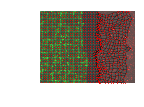

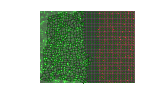

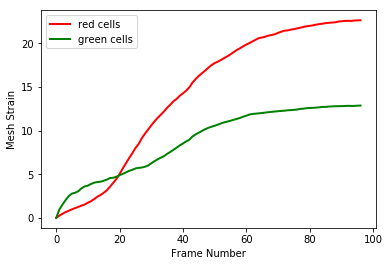

In [9]:
"""
6. Normalised mesh strain, computes the mesh strain curve for each colour and combines them to produce the normalised mesh strain for the video which is used as a motion signature.
"""
print 'Computing normalised MOSES Mesh strain curve...'
mesh_strain_r = compute_MOSES_mesh_strain_curve(MOSES_mesh_strain_time_r, normalise=False)
mesh_strain_g = compute_MOSES_mesh_strain_curve(MOSES_mesh_strain_time_g, normalise=False)

mesh_strain_curve_video = .5*(mesh_strain_r+mesh_strain_g)
normalised_mesh_strain_curve_video = mesh_strain_curve_video/ np.max(mesh_strain_curve_video)

plt.figure()
plt.plot(mesh_strain_r, 'r-', lw=2., label='red cells')
plt.plot(mesh_strain_g, 'g-', lw=2., label='green cells')
plt.xlabel('Frame Number')
plt.ylabel('Mesh Strain')
plt.legend(loc='best')
plt.savefig('MOSES_mesh_strain_curve_red-green.png', dpi=80, bbox_inches='tight', pad_inches=0)
plt.show()

### Gap Closure Inference

In wound healing type assays and two cell *in-vitro* migrating assays in general, the motion dynamics before and after the two epithelial cell populations meet can be different. It is useful to be extract the frame in which the populations close the initial gap.

Inferring the gap closure frame...


/Users/felix/anaconda/lib/python2.7/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "
/Users/felix/anaconda/lib/python2.7/site-packages/matplotlib/legend.py:326: UserWarning: Unrecognized location "top right". Falling back on "best"; valid locations are
	right
	center left
	upper right
	lower right
	best
	center
	lower left
	center right
	upper left
	upper center
	lower center

  six.iterkeys(self.codes))))


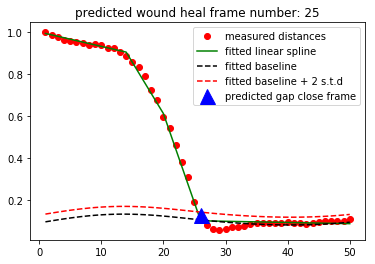

predicted gap closure frame is: 26


In [10]:
"""
7. Infer the gap closure frame, using image segmentation and plot the diagnostics. We can set the flag to False to suppress the plot.
"""
print 'Inferring the gap closure frame...'
wound_closure_frame = wound_sweep_area_segmentation(vidstack, spixel_size, max_frame=50, n_sweeps=50, n_points_keep=1, n_clusters=2, p_als=0.001, to_plot=True)

print 'predicted gap closure frame is: %d' %(wound_closure_frame)

### Step 3: Computation of the Presented Metrics in the Paper

    a) Boundary formation index
    b) Motion Stability Index
    c) Max. Velocity cross correlation Index
    d) Spatial Correlation 
    e) Mesh Disorder Index

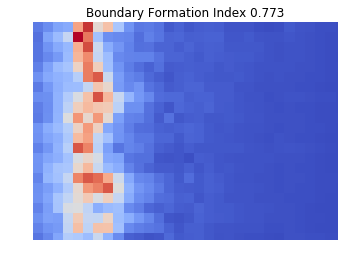

In [11]:
#==============================================================================
#     a) Boundary Formation Index.
#==============================================================================

# we first compute the motion saliency map.
final_saliency_map_r, spatial_time_saliency_map_r = compute_motion_saliency_map(meantracks_r, dist_thresh=5.*spixel_size, shape=(n_rows, n_cols), filt=1, filt_size=spixel_size)
final_saliency_map_g, spatial_time_saliency_map_g = compute_motion_saliency_map(meantracks_g, dist_thresh=5.*spixel_size, shape=(n_rows, n_cols), filt=1, filt_size=spixel_size)

boundary_formation_index, av_saliency_map = compute_boundary_formation_index(final_saliency_map_r, final_saliency_map_g, spixel_size, pad_multiple=3)

fig = plt.figure()
plt.title('Boundary Formation Index %.3f' %(boundary_formation_index))
plt.imshow(av_saliency_map, cmap='coolwarm')
plt.axis('off')
plt.grid('off')
fig.savefig('av_saliency_map.png', dpi=80, bbox_inches='tight', pad_inches=0)
plt.show()

In [12]:
#==============================================================================
#     b) Motion Stability Index.
#==============================================================================

# returns the combined normalised mesh strain curve.
# the motion stability index uses an average over the last number of frame specified by the flag, last_frames. One should set this to approximately cover the plateau region of the strain curve. 
motion_stability_index, normalised_mesh_strain_curve = compute_MOSES_motion_stability_index(MOSES_mesh_strain_time_r, MOSES_mesh_strain_time_g, last_frames=5)

print 'motion stability index: %.3f' %(motion_stability_index)

motion stability index: 0.900


In [13]:
#==============================================================================
#     c) Max. Velocity Cross-Correlation Index
#==============================================================================
(max_vccf_before, _), (max_vccf_after, _) = compute_max_vccf_cells_before_after_gap(meantracks_r, meantracks_g, wound_heal_frame=wound_closure_frame, err_frame=5)

print 'max velocity cross-correlation before: %.3f' %(max_vccf_before)
print 'max velocity cross-correlation after: %.3f' %(max_vccf_after)

max velocity cross-correlation before: 0.020
max velocity cross-correlation after: 0.221


/Users/felix/anaconda/lib/python2.7/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
Motion_Analysis/mesh_statistics_tools.py:987: RuntimeWarning: Mean of empty slice
  av_corr = np.nanmean([x_corr, y_corr])
Motion_Analysis/mesh_statistics_tools.py:957: RuntimeWarning: Mean of empty slice
  time_correlations.append(np.nanmean(velocity_corr))


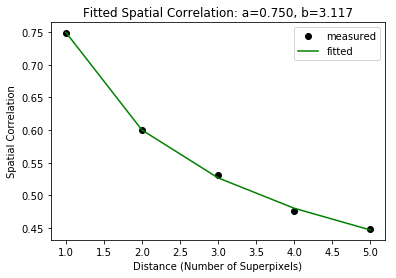

In [14]:
#==============================================================================
#     d) Spatial Correlation. 
#==============================================================================
spatial_corr_curve, (spatial_corr_pred,  a_value, b_value, r_value) = compute_spatial_correlation_function(meantracks_r, wound_closure_frame, wound_heal_err=5, dist_range=np.arange(1,6,1))

# plot the curve and the fitted curve to y=a*exp(-x/b) to get the (a,b) parameters. 
plt.figure()
plt.title('Fitted Spatial Correlation: a=%.3f, b=%.3f' %(a_value, b_value))
plt.plot(np.arange(1,6,1), spatial_corr_curve, 'ko', label='measured')
plt.plot(np.arange(1,6,1), spatial_corr_pred, 'g-', label='fitted')
plt.xlabel('Distance (Number of Superpixels)')
plt.ylabel('Spatial Correlation')
plt.legend(loc='best')
plt.show()

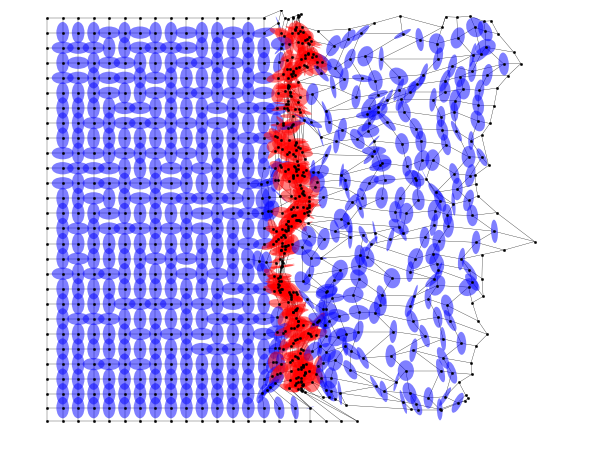

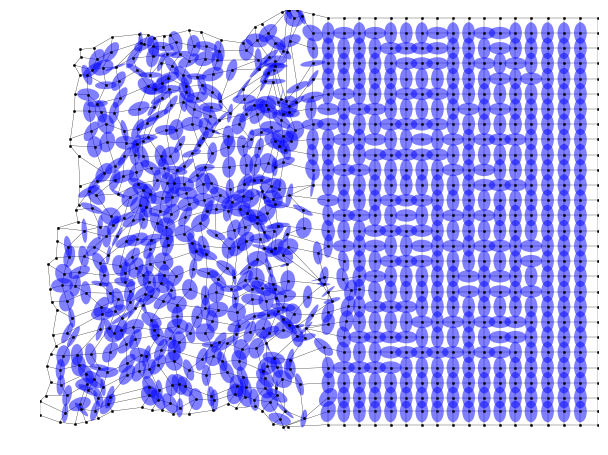

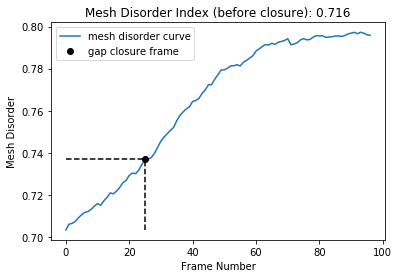

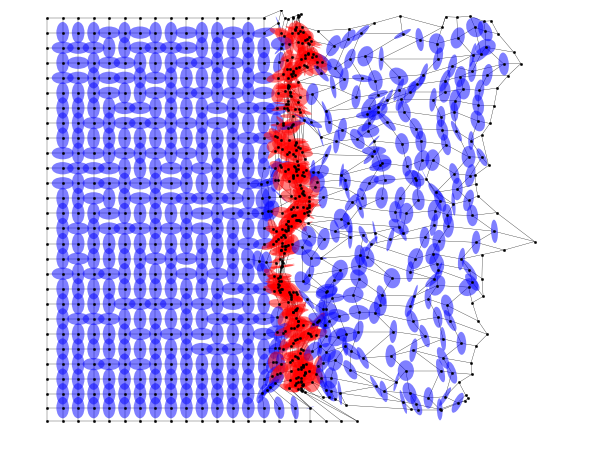

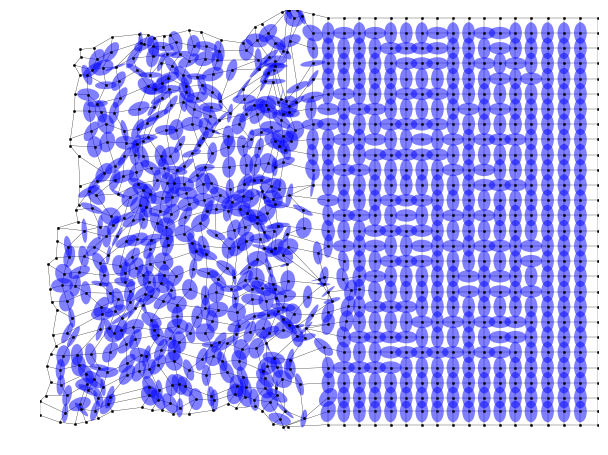

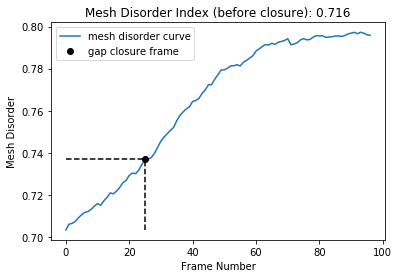

Mesh disorder index of video: 0.716


In [16]:
#==============================================================================
#     e) Mesh Disorder Index + visualization, red ellipses show excluded regions. To suppress visualization use to_plot=True.
#==============================================================================
mesh_disorder_curve_r = compute_mesh_disorder(meantracks_r, MOSES_mesh_neighborlist_r, 2*4, to_plot=True, frame_plot=30) # if to_plot, displays the mesh with ellipses. red ellipses is excluded points due to high density as set by the threshold, blue ellipses is included in calculation.
mesh_disorder_curve_g = compute_mesh_disorder(meantracks_g, MOSES_mesh_neighborlist_g, 2*4, to_plot=True, frame_plot=30)

av_mesh_disorder_curve = .5*(mesh_disorder_curve_r+mesh_disorder_curve_g)
mesh_disorder_index = compute_mesh_disorder_index(av_mesh_disorder_curve, wound_closure_frame) # mesh disorder index is just the median value before wound closure.

plt.figure()
plt.title('Mesh Disorder Index (before closure): %.3f' %(mesh_disorder_index))
plt.plot(av_mesh_disorder_curve, label='mesh disorder curve')
plt.plot(wound_closure_frame-1, av_mesh_disorder_curve[wound_closure_frame-1], 'ko', label='gap closure frame')
plt.plot([wound_closure_frame-1, wound_closure_frame-1], [np.min(av_mesh_disorder_curve), av_mesh_disorder_curve[wound_closure_frame-1]], 'k--')
plt.plot([0, wound_closure_frame-1], [av_mesh_disorder_curve[wound_closure_frame-1], av_mesh_disorder_curve[wound_closure_frame-1]], 'k--')
plt.legend(loc='best')
plt.xlabel('Frame Number')
plt.ylabel('Mesh Disorder')
plt.show()

print 'Mesh disorder index of video: %.3f' %(mesh_disorder_index)
